In [3]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Pandas display options to show all columns and all rows if necessary. Puts a lot of strain of processor

In [38]:
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None
pd.options.display.float_format= '{:.2f}'.format

In [4]:
ticker_names = pd.read_csv(os.path.join('Resources', 'other-listed.csv')).rename(columns={'ACT Symbol':'Ticker'}).\
drop(columns=['Security Name', 'Exchange', 'CQS Symbol',
       'ETF', 'Round Lot Size', 'Test Issue', 'NASDAQ Symbol'])


nyse = pd.read_csv(os.path.join('Resources', 'nyse.csv'))
nasdaq = pd.read_csv(os.path.join('Resources', 'nasdaq.csv'))
frames = [nyse, nasdaq]

tickers = pd.concat(frames).sort_values(by='Ticker')

In [5]:
data_2018 = pd.read_csv(os.path.join('Resources', '2018_Financial_Data.csv')).\
rename(columns={'Unnamed: 0':'Ticker'}).\
sort_values(by='Ticker').\
reset_index(drop=True)

df = tickers.merge(data_2018, on='Ticker')

Note: In *__data_2018__* we had 4392 observations. When we merged with our *__tickers__* dataframe which had 6600+ tickers and company names from exchanges we lost ~300 observations. These can be retrieved with 
``` 
data_2018[~data_2018.Ticker.isin(tickers['Ticker'])]
```

## Conditional Filtering

In [166]:
tickers[tickers['Company Name'].str.contains('ETF') == True];

In [165]:
df[df['Company Name'].str.contains('S&P') == True];

In [183]:
df[df['Ticker'].str.startswith('X') == True];

In [132]:
df[df['Sector'] == "Consumer Cyclical"];

In [184]:
data_2018[~data_2018.Ticker.isin(tickers['Ticker'])]

,Ticker,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2019 PRICE VAR [%],Class
2,AABA,21199000000.00,277.93,nan,332804000.00,nan,nan,80794000.00,-12678000000.00,-178480000.00,...,-0.07,0.00,-0.41,0.06,0.05,nan,nan,Financial Services,25.26,1
4,AAMC,15926000.00,-0.12,0.00,15926000.00,0.00,22534000.00,22534000.00,-6608000.00,0.00,...,-0.04,0.00,-0.18,-0.03,0.00,0.00,-0.12,Financial Services,-58.85,0
12,AAU,0.00,0.00,0.00,0.00,0.00,1428731.85,3482766.67,-3482766.67,0.00,...,0.03,0.00,0.04,-0.09,0.00,0.00,0.17,Basic Materials,-15.71,0
20,ABDC,28967980.00,-0.13,3309307.00,25658673.00,0.00,2060316.00,4107827.00,21550846.00,6649567.00,...,-0.58,0.00,-0.18,-0.06,-0.42,0.00,0.30,Financial Services,51.09,1
24,ABIL,539000.00,-0.82,1637000.00,-1098000.00,0.00,9072000.00,9072000.00,-10170000.00,19000.00,...,-0.50,-1.00,0.27,5.01,0.00,0.00,0.00,Technology,-83.62,0
43,ACHN,0.00,0.00,0.00,0.00,50118000.00,23896000.00,75914000.00,-75914000.00,36000.00,...,4.83,0.00,-0.18,-0.19,-0.56,-0.21,-0.08,Healthcare,256.80,1
59,ACU,137321395.00,0.05,86672413.00,50648982.00,0.00,43192076.00,43192076.00,7456906.00,1858224.00,...,-0.04,0.03,-0.05,0.05,-0.07,0.00,0.08,Consumer Defensive,63.38,1
60,ACY,27116400.00,-0.24,636000.00,26480400.00,0.00,2936100.00,26028400.00,452000.00,9506000.00,...,0.04,0.00,-0.08,-0.13,-0.10,0.00,0.51,Industrials,-50.66,0
71,ADOM,5011000.00,10.79,4878000.00,133000.00,686000.00,10651000.00,11508000.00,-11375000.00,-189000.00,...,0.00,-1.00,1.04,2.00,-0.21,0.17,-0.43,Consumer Cyclical,-43.18,0
82,AE,1750213000.00,0.32,1729214000.00,20999000.00,0.00,8937000.00,19591000.00,1408000.00,109000.00,...,-0.29,0.87,-0.01,-0.00,1.42,0.00,-0.08,Energy,-2.37,0


## Graphs and Visualizations

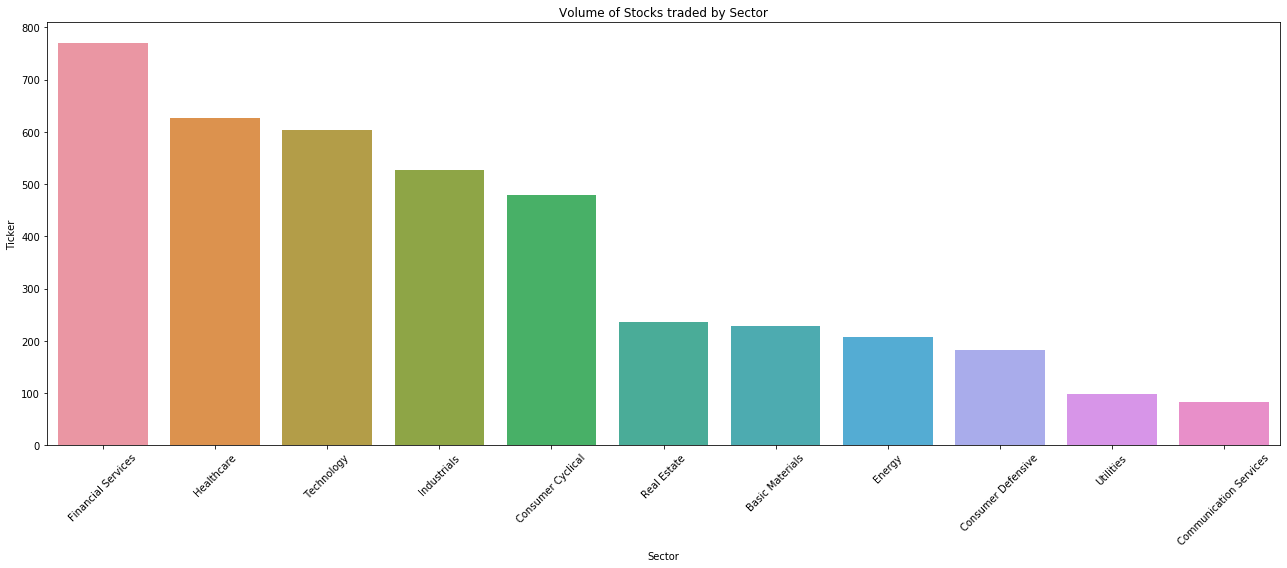

In [130]:
sector_count = pd.DataFrame(df.groupby(['Sector']).count()['Ticker']).reset_index().sort_values(by='Ticker', ascending=False)

plt.figure(figsize=(18,8))
plt.title('Volume of Stocks traded by Sector')
sns.barplot(x = sector_count['Sector'], y = sector_count['Ticker']).set_xticklabels(labels = sector_count['Sector'], rotation=45)
plt.tight_layout()
# plt.savefig(os.path.join('Figures','StockVolume_Sector.png'))

In [ ]:
# df.to_csv(os.path.join('2018_data.csv'))